In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 29 13:43:16 2019

@author: jorgeagr
"""
import os
import obspy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import obspy
from tensorflow.keras.models import load_model
from sklearn.cluster import DBSCAN
import pandas as pd

golden_ratio = (np.sqrt(5) + 1) / 2
width = 15
height = width / golden_ratio

mpl.rcParams['figure.figsize'] = (width, height)
mpl.rcParams['font.sans-serif'] = 'Helvetica'

#mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 22
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 16
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['xtick.minor.size'] = 12
mpl.rcParams['xtick.labelsize'] = 36
mpl.rcParams['ytick.major.size'] = 16
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 12
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.labelsize'] = 36
mpl.rcParams['axes.linewidth'] = 1.5

In [3]:
# FIG 2 B

model = load_model('../../seyesmolite/models/SS40/SS40.h5')
test_files = np.array([file.rstrip('.npz') for file in np.load('../../seyesmolite/models/SS40/train_logs/train_test_split1.npz')['test']])

arrival_var = 't6'
th_arrival_var = 't2'
window_before = 0
window_after = 40
sample_rate = 10
total_time = 400

arrivals = np.zeros(len(test_files))
preds = np.zeros(len(test_files))
for i, file in enumerate(test_files):
    seis = obspy.read('/mnt/d/SS_kept/'+file)[0]
    #preds[i] = seis.stats.sac.t2 - seis.stats.sac.b
    #actuals[i] = seis.stats.sac.t6 - seis.stats.sac.b
    b = seis.stats.sac['b']
    # The beginning time may not be 0, so shift all attribtues to be so
    shift = -b
    b = b + shift
    # End time
    e = seis.stats.sac['e'] + shift
    # Theoretical onset arrival time + shift
    if th_arrival_var == arrival_var:
        th_arrival = seis.stats.sac[arrival_var] + shift - np.random.rand() * 20
    else:
        th_arrival = seis.stats.sac[th_arrival_var] + shift
    # Picked maximum arrival time + shift
    arrival = seis.stats.sac[arrival_var] + shift
    
    # Theoretical arrival may be something unruly, so assign some random
    # shift from the picked arrival
    if not (b < th_arrival < e):
        th_arrival = arrival - 20 * np.random.rand()
    
    amp = seis.data
    time = seis.times()
    
    rand_arrival = th_arrival
    init = int(np.round((rand_arrival - window_before)*sample_rate))
    end = init + total_time
    if not (time[init] < arrival < time[end]):
        init = int(np.round((arrival - 15 * np.random.rand() - window_before)*sample_rate))
        end = init + total_time
    amp_i = amp[init:end]
    # Normalize by absolute peak, [-1, 1]
    amp_i = amp_i / np.abs(amp_i).max()
    arrivals[i] = arrival - time[init]
    preds[i] = model.predict(amp_i.reshape((1, 400, 1)))

/home/jorgeagr/miniconda3/envs/neuralpick/lib/python3.7/site-packages/obspy/core/trace.py:220: UserWarning: Calibration factor set to 0.0!
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


avg abs err: 0.0840954212207 +/- 0.153217385917
min error: 0.0
max error: 6.80988769531


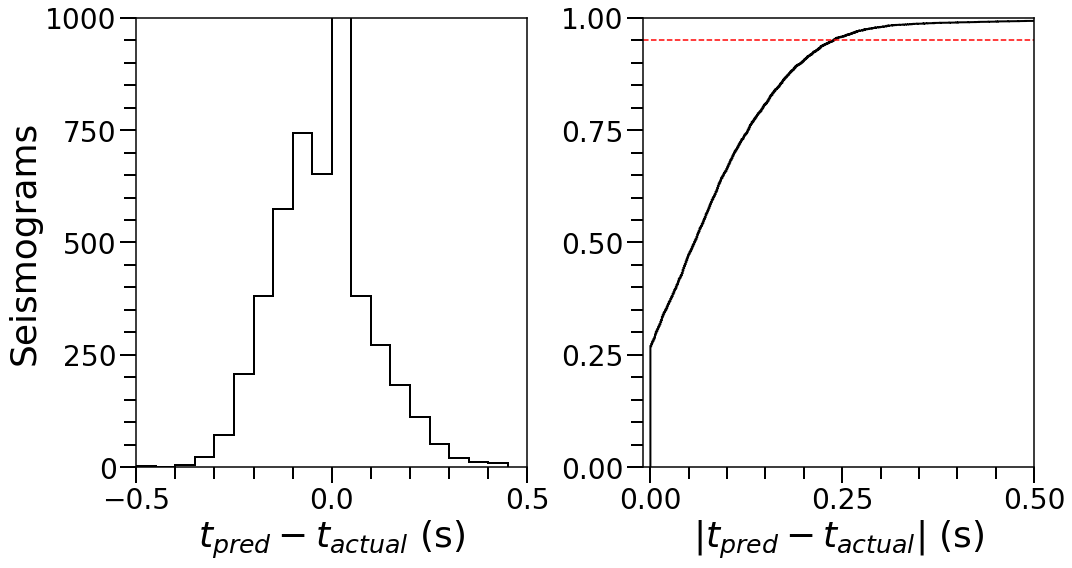

In [4]:
shift_error = preds - arrivals
print('avg abs err:', np.abs(shift_error).mean(), '+/-', np.abs(shift_error).std())
print('min error:', np.abs(shift_error).min())
print('max error:', np.abs(shift_error).max())
#print(len(np.where(shift_error<0)[0])/len(shift_error))
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))
weights = np.ones_like(shift_error)/len(shift_error)
shift_hist = ax[0].hist(shift_error, np.arange(-0.5, 0.5, 0.05), histtype='step', align='mid', 
        color='black', linewidth=2)#, weights=weights, cumulative=False,)# label='Shifted Windows')
#simple_hist = ax.hist(simple_error, np.arange(-1, 1, 0.1), histtype='step', align='mid',
#               color='green', linewidth=2, weights=weights, cumulative=False, label='Single Window')
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylim(0, 1000)
ax[0].yaxis.set_major_locator(mtick.MultipleLocator(250))
ax[0].yaxis.set_minor_locator(mtick.MultipleLocator(50))
ax[0].xaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax[0].xaxis.set_minor_locator(mtick.MultipleLocator(0.1))
ax[0].set_xlabel(r'$t_{pred} - t_{actual}$ (s)', fontsize=36)
ax[0].set_ylabel('Seismograms', fontsize=36)
#ax.legend()
#fig.tight_layout(pad=0.5)
#fig.savefig('../figs/shift_v_simple_hist.png', dpi=250)
#fig.savefig('../figs/shift_v_simple_hist.svg', dpi=250)

#fig2, ax2 = plt.subplots()
shift_cum = ax[1].hist(np.abs(shift_error), np.arange(0, 1.1, 0.001), histtype='step', align='mid',
        color='black', linewidth=2, weights=weights, cumulative=True,)# label='Shifted Windows')
#simple_cum = ax2.hist(np.abs(shift_error), np.arange(0, 1.1, 0.001), histtype='step', align='mid', 
#        color='green', linewidth=1.5, weights=weights, cumulative=True, linestyle='--', label='Single Window')
ax[1].axhline(0.95, linestyle='--', color='red')
ax[1].set_xlim(-0.01, 0.5)
ax[1].set_ylim(0, 1)
ax[1].xaxis.set_major_locator(mtick.MultipleLocator(0.25))
ax[1].yaxis.set_major_locator(mtick.MultipleLocator(0.25))
ax[1].xaxis.set_minor_locator(mtick.MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(mtick.MultipleLocator(0.05))
ax[1].set_xlabel(r'$|t_{pred} - t_{actual}|$ (s)', fontsize=36)
#ax[1].set_ylabel('Fraction of counts')
#ax2.legend(loc='lower right')
fig.tight_layout(pad=0.5)
fig.savefig('../model_accuracy.eps', dpi=200)
#fig2.savefig('../figs/shift_v_simple_cumhist.png', dpi=250)
#fig2.savefig('../figs/shift_v_simple_cumhist.svg', dpi=250)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


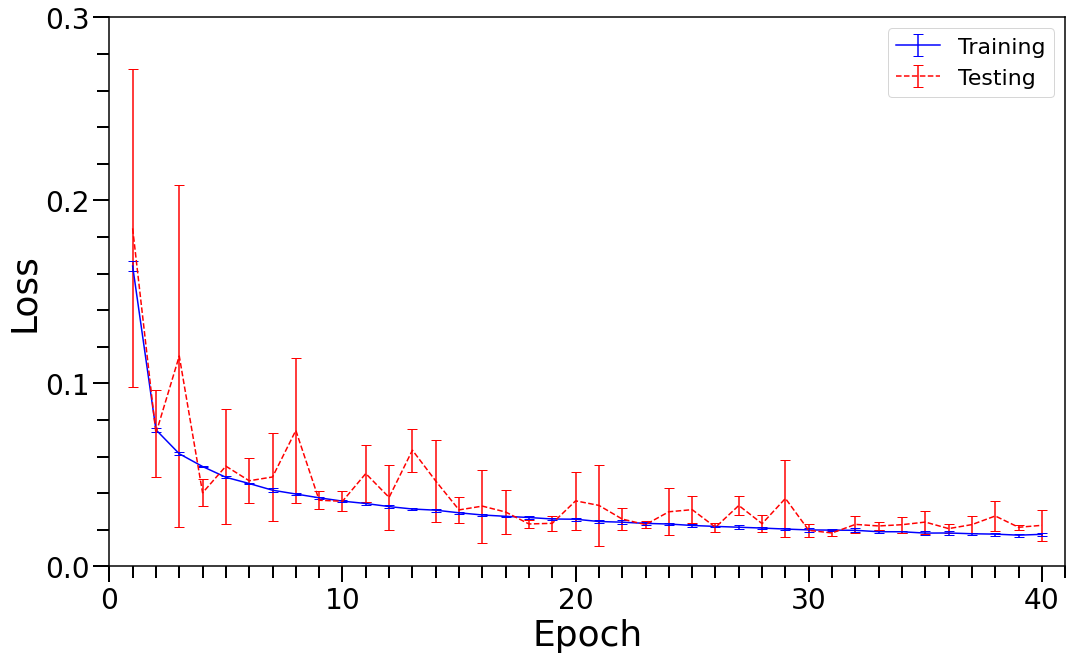

In [5]:
# FIG 2 C

model_log = np.load('../../pickerlite/models/SS_40_model_training_logs.npz')
loss = model_log['loss']
val_loss = model_log['val_loss']

train_avg = loss.mean(axis=0)
test_avg = val_loss.mean(axis=0)
train_std = loss.std(axis=0)
test_std = val_loss.std(axis=0)
epochs = np.arange(40)+1
fig, ax = plt.subplots()
ax.errorbar(epochs, train_avg, yerr=train_std, capsize=5, color='blue', label='Training')
ax.errorbar(epochs, test_avg, yerr=test_std, capsize=5, color='red', linestyle='--', label='Testing')
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_locator(mtick.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(mtick.MultipleLocator(1))
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.02))
ax.set_xlim(0, 41)
ax.set_ylim(0, 0.3)
ax.set_xlabel('Epoch', fontsize=36)
ax.set_ylabel('Loss', fontsize=36)
ax.legend()
fig.tight_layout(pad=0.5)
fig.savefig('../model_loss.eps', dpi=200)

In [6]:
# FIG 3 A

file_dir = '/mnt/d/SS_kept/'
file = '20160101A.india.DRLN.BHT.s_fil'
#index = args.index
save = True
name = 'scanning_eg'
begin_t = 40
end_t = 90
resample_Hz = 10

if not file:
    file = sorted(os.listdir(file_dir))[index]
extension = '.{}'.format(file.split('.')[-1])

if not name:
    name = file.rstrip('.'+extension)

def cut_Window(cross_sec, times, t_i, t_f):
    #init = np.where(times == np.round(t_i, 1))[0][0]
    #end = np.where(times == np.round(t_f, 1))[0][0]
    init = int(np.round(t_i*resample_Hz))
    end = int(np.round(t_f*resample_Hz))
    
    return cross_sec[init:end]

def scan(seis, times, time_i_grid, time_f_grid, shift, model, negative=False):
    window_preds = np.zeros(len(time_i_grid))
    for i, t_i, t_f in zip(range(len(time_i_grid)), time_i_grid, time_f_grid):
        seis_window = cut_Window(seis, times, t_i, t_f) * (-1)**negative
        seis_window = seis_window / np.abs(seis_window).max()
        # Take the absolute value of the prediction to remove any wonky behavior in finding the max
        # Doesn't matter since they are bad predictions anyways
        window_preds[i] += np.abs(model.predict(seis_window.reshape(1, len(seis_window), 1))[0][0]) + t_i
    return window_preds

model = load_model('../../seyesmolite/models/SS40/SS40.h5')
seismogram = obspy.read(file_dir+file)[0]
times = seismogram.times()
time_window = 40

seis = seismogram.data / np.abs(seismogram.data).max()
shift = -seismogram.stats.sac.b
begin_time = -np.abs(begin_t)
begin_time = np.round(begin_time + shift, decimals=1)
end_time = -np.abs(end_t)
end_time = np.abs(end_t)
end_time = np.round(end_time + shift, decimals=1)

time_i_grid = np.arange(begin_time, end_time - time_window, 0.1)
time_f_grid = np.arange(begin_time + time_window, end_time, 0.1)

window_preds = scan(seis, times, time_i_grid, time_f_grid, shift, model)
times = times - shift

grouped_preds = window_preds
dbscan = DBSCAN(0.05, 2)
dbscan.fit(window_preds.reshape(-1,1))
clusters, counts = np.unique(dbscan.labels_, return_counts=True)
for c in clusters:
    if c != -1:
        grouped_preds[np.where(dbscan.labels_ == c)] = np.ones_like(grouped_preds[dbscan.labels_ == c]) * grouped_preds[dbscan.labels_ == c].mean()

KeyboardInterrupt: 

NameError: name 'window_preds' is not defined

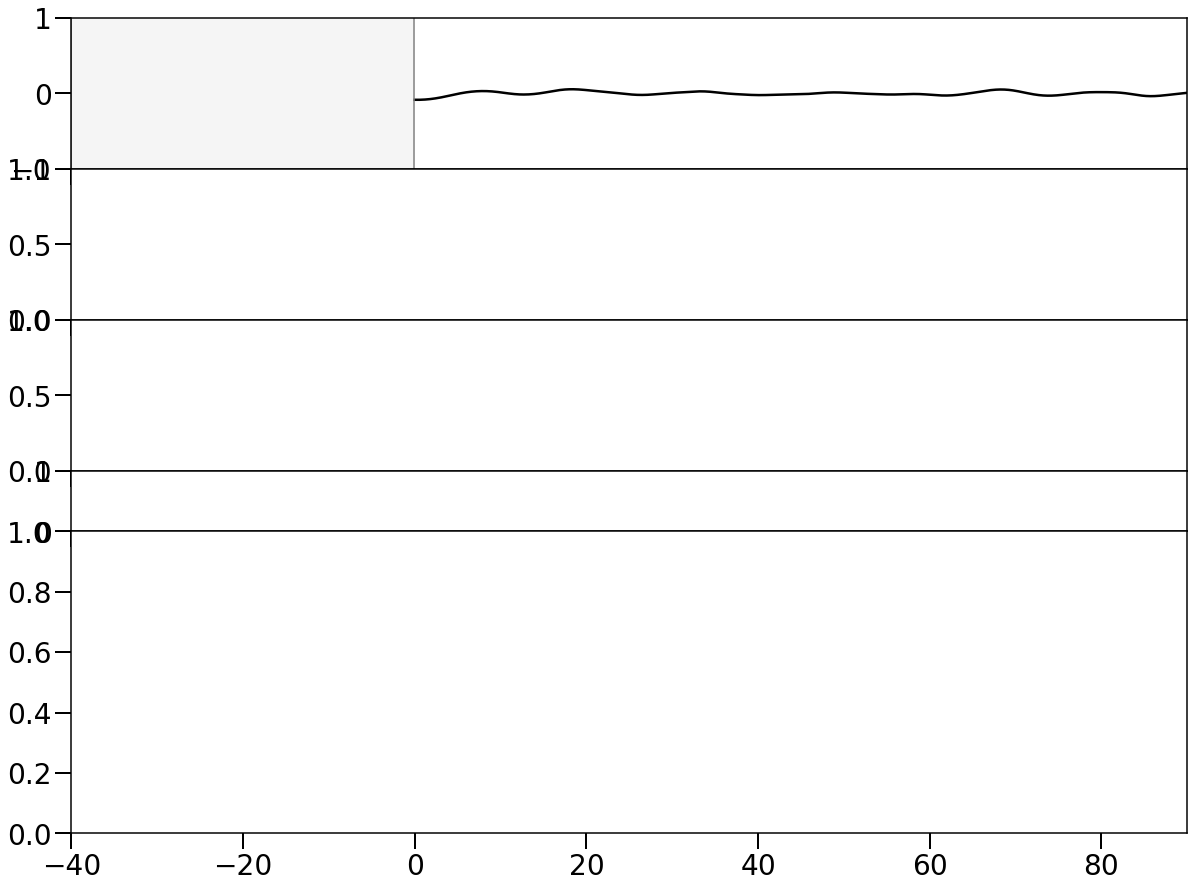

In [7]:
steps = [0, 150, 300]
fig, axis = plt.subplots(figsize=(20,15), nrows=5, sharex=True, gridspec_kw={'hspace': 0,
                                                            'height_ratios': [1, 1, 1, 0.4, 2]})#figsize=(15,5))
for n, ax in enumerate(axis[:-2]):
    ax.set_ylim(-1, 1)
    ax.set_xlim(-begin_t, end_t)
    #ax.yaxis.set_major_locator(mtick.MultipleLocator(1))
    #ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.5))
    ax.plot(times, seis, linewidth=2.5, color='black')
    win_init = ax.axvline(time_i_grid[steps[n]]-shift, color='gray', label='Window Limit')
    win_end = ax.axvline(time_f_grid[steps[n]]-shift, color='gray')
    y_grid = np.array([-1, 1])
    win_col = ax.fill_betweenx(y_grid, np.ones_like(y_grid)*(time_i_grid[steps[n]]-shift),
                               np.ones_like(y_grid)*(time_f_grid[steps[n]]-shift), color='whitesmoke')
    pred = ax.axvline(window_preds[steps[n]]-shift, color='red', linestyle='--', label='Arrival Prediction', linewidth=2.5)
    #ax.legend()
    ax.tick_params(axis='y', left=False, labelleft=False)

axis[3].set_visible(False)

axis[1].set_ylabel('Amplitude', fontsize=36)
axis[-1].set_xlabel('Time (s)', fontsize=36)
axis[-1].xaxis.set_major_locator(mtick.MultipleLocator(20))
axis[-1].xaxis.set_minor_locator(mtick.MultipleLocator(10))
axis[0].legend(loc='upper right')

axis[-1].hist(grouped_preds-shift, np.arange(begin_time, end_time + 0.1, 0.1)-shift,
    color='red', weights=np.ones(len(window_preds)) / 400, linewidth=2.5)
axis[-1].set_ylabel('Quality', fontsize=36)
axis[-1].yaxis.set_major_locator(mtick.MultipleLocator(0.2))
axis[-1].yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
axis[-1].set_ylim(0, 1)

fig.tight_layout(pad=0.5)
fig.savefig('../{}.eps'.format(name), dpi=200)

In [8]:
# FIG 3 B

def cut_Window(cross_sec, times, t_i, t_f):
    init = np.where(times == np.round(t_i, 1))[0][0]
    end = np.where(times == np.round(t_f, 1))[0][0]
    
    return cross_sec[init:end]

def shift_Max(seis, pred_var):
    data = seis.data
    time = seis.times()
    arrival = 0
    new_arrival = seis.stats.sac[pred_var]
    #for i in range(3):
    while (new_arrival - arrival) != 0:
        arrival = new_arrival
        init = np.where(time > (arrival - 1))[0][0]
        end = np.where(time > (arrival + 1))[0][0]
        
        amp_max = np.argmax(np.abs(data[init:end]))
        time_ind = np.arange(init, end, 1)[amp_max]
        
        new_arrival = time[time_ind]
        #print(new_arr)
        #if np.abs(new_arr - arrival) < 1e-2:
        #    break
    return arrival

model = 'SS40'
pos_model = load_model('../../seyesmolite/models/{}/{}.h5'.format(model, model))
time_window = 40

cap = '15'
file = 'n15_156.50'
cs = obspy.read('/mnt/d/'+cap+'caps_deg/'+file+'.sac')

cs = cs[0].resample(10)
times = cs.times()

shift = -cs.stats.sac.b
begin_time = cs.stats.sac.b#-np.abs(-280) # Seconds before main arrival. Will become an input.
begin_time = np.round(begin_time + shift, decimals=1)
end_time = cs.stats.sac.e#-np.abs(-80) # ditto above
end_time = np.round(end_time + shift, decimals=1)

time_i_grid = np.arange(begin_time, end_time - time_window, 0.1)
time_f_grid = np.arange(begin_time + time_window, end_time, 0.1)

window_preds = np.zeros(len(time_i_grid))
for i, t_i, t_f in zip(range(len(time_i_grid)), time_i_grid, time_f_grid):
    if t_f > shift:
        pass#break
    cs_window = cut_Window(cs, times, t_i, t_f)
    cs_window = cs_window / np.abs(cs_window).max()
    # Take the absolute value of the prediction to remove any wonky behavior in finding the max
    # Doesn't matter since they are bad predictions anyways
    cs.stats.sac.t6 = np.abs(pos_model.predict(cs_window.reshape(1, len(cs_window), 1))[0][0]) + t_i
    window_preds[i] += cs.stats.sac.t6#shift_Max(cs, 't6')

eps=0.05
min_neighbors=2
dbscan = DBSCAN(eps, min_neighbors)
dbscan.fit(window_preds.reshape(-1,1))
clusters, counts = np.unique(dbscan.labels_, return_counts=True)

grouped_preds = window_preds
for c in clusters:
    if c != -1:
        grouped_preds[np.where(dbscan.labels_ == c)] = np.ones_like(grouped_preds[dbscan.labels_ == c]) * grouped_preds[dbscan.labels_ == c].mean()

if -1 in clusters:
    clusters = clusters[1:]
    counts = counts[1:]
arrivals = np.zeros(len(clusters))
arrivals_qual = np.zeros(len(clusters))
for c in clusters:
    arrivals[c] = np.mean(window_preds[dbscan.labels_ ==  c])
    arrivals_qual[c] = counts[c]/400
times = times-shift

KeyboardInterrupt: 

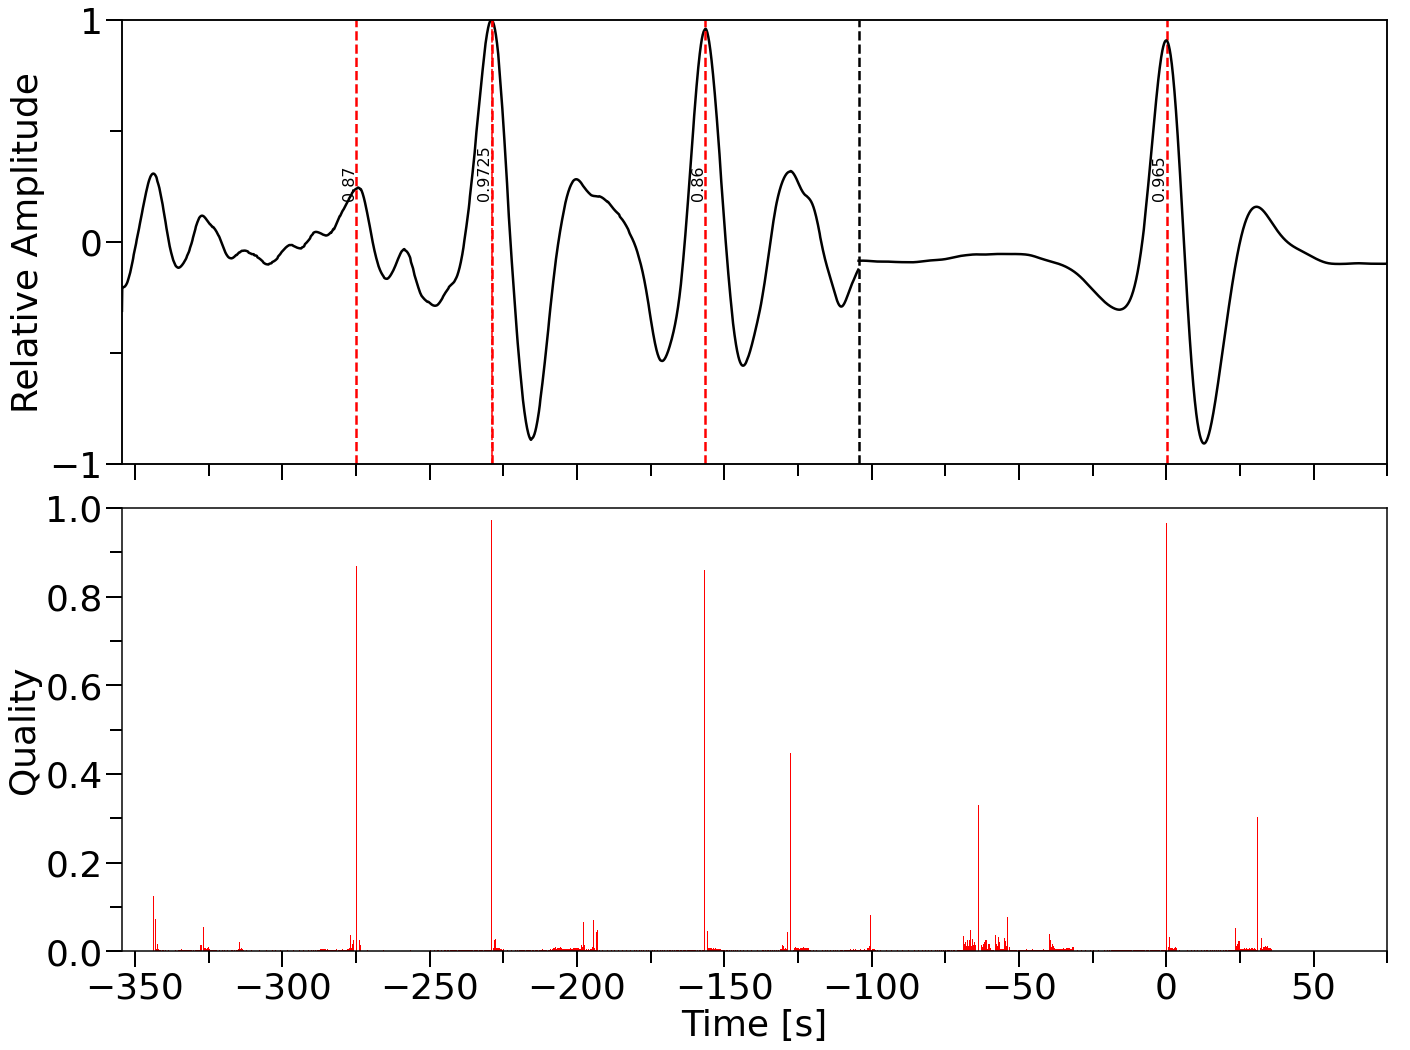

In [106]:
fig, ax = plt.subplots(figsize=(20,15), nrows=2, sharex=True)
cut = 2500
ax[0].plot(times[:cut], cs.data[:cut] / np.abs(cs.data[:cut]).max(), color='black', linewidth=2.5)
for i, ar in enumerate(arrivals[np.argsort(arrivals_qual)][-4:]):
    ax[0].axvline(ar-shift, color='red', linestyle='--', linewidth=2.5)
    ax[0].text(ar-5-shift, 0.2, np.sort(arrivals_qual)[-4:][i], rotation=90, fontsize=16)
ax[0].axvline(ar-shift, color='red', linestyle='--', label='model')
ax[0].axvline(cut/10 - shift, color='black', linestyle='--', linewidth=2.5)

ax2 = ax[0].twinx()
ax2.plot(times[cut:], cs.data[cut:] / np.abs(cs.data[cut:]).max(), color='black', linewidth=2.5)
ax2.axes.get_yaxis().set_visible(False)

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(times.min(), times.max())
ax[1].set_xlabel('Time [s]', fontsize=36)
ax[0].xaxis.set_major_locator(plt.NullLocator())
ax[0].set_ylabel('Relative Amplitude', fontsize=36)

ax[1].hist(grouped_preds-shift, np.arange(begin_time, end_time+0.3, 0.3)-shift, color='red',
           weights=np.ones(len(grouped_preds)) / (time_window*10), linewidth=2.5)
ax[1].set_ylabel('Quality', fontsize=36)
ax[1].set_ylim(0, 1)
ax[1].xaxis.set_major_locator(mtick.MultipleLocator(50))
ax[1].xaxis.set_minor_locator(mtick.MultipleLocator(25))
ax[0].yaxis.set_major_locator(mtick.MultipleLocator(1))
ax[0].yaxis.set_minor_locator(mtick.MultipleLocator(0.5))
ax[1].yaxis.set_major_locator(mtick.MultipleLocator(0.2))
ax[1].yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
fig.tight_layout(pad=1)
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('../crosssection_preds.eps', dpi=200)

In [11]:
# FIG 4 A
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

def filter_Data(condition_array, *arrays):
    new_arrays = []
    for array in arrays:
        new_arrays.append(array[condition_array])
    return new_arrays

def get_Predictions(pred_csv_path, file, qual_cut=0.6):
    df = pd.read_csv(pred_csv_path + file)
    preds = 0 
    for key in df.keys():
        if 'pred' in key:
            preds += 1
    pred_inds = np.array([2+4*i for i in range(preds)])
    err_inds = pred_inds + 1
    amp_inds = err_inds + 1
    qual_inds = amp_inds + 1
    
    files = df['file'].values
    arrivals = df.values[:,pred_inds]#.flatten()
    gcarcs = df['gcarc'].values
    errors = df.values[:,err_inds].flatten()
    amps = df.values[:,amp_inds].flatten()
    qualities = df.values[:,qual_inds]
    
    arrivals[qualities < qual_cut] = 0
    qualities = qualities.flatten()
    arrivals_inds = np.meshgrid(np.arange(arrivals.shape[1]),
                               np.arange(arrivals.shape[0]))[1].flatten()
    gcarcs = np.meshgrid(np.arange(arrivals.shape[1]), gcarcs)[1].flatten()
    files = np.meshgrid(np.arange(arrivals.shape[1]), files)[1].flatten()
    arrivals = arrivals.flatten()
    
    arrivals_inds, gcarcs, qualities, errors, amps, arrivals, files = filter_Data(arrivals != 0, arrivals_inds, gcarcs,
                                                                           qualities, errors, amps, arrivals, files)
    arrivals_inds, gcarcs, qualities, errors, amps, arrivals, files = filter_Data(gcarcs >= 100, arrivals_inds, gcarcs,
                                                                           qualities, errors, amps, arrivals, files)
    arrivals_inds, gcarcs, qualities, errors, amps, arrivals, files = filter_Data(arrivals > -300, arrivals_inds, gcarcs,
                                                                           qualities, errors, amps, arrivals, files)
    
    return gcarcs, arrivals, errors, qualities, amps, files

def discontinuity_model(dat_path, precursor, depth, model):
    df_disc = pd.read_csv('{}S{}Stimes_{}_{}.dat'.format(dat_path, precursor, depth, model), sep=' ', header=None)
    df_main = pd.read_csv('{}SStimes_{}_{}.dat'.format(dat_path, depth, model), sep=' ', header=None)
    df_disc[1] = (df_disc - df_main)[1]
    func = interp1d(df_disc[0].values, df_disc[1].values)
    
    return func

def find_Relevant(arrivals, gcarcs, errors, qualities, files, init_time, end_time, uncertainty, sigmas, weighted=True):
    condition = (arrivals < init_time) & (arrivals > end_time)
    arrivals = arrivals[condition]
    gcarcs = gcarcs[condition]
    errors = errors[condition]
    qualities = qualities[condition]
    files = files[condition]
    
    percent_data = 1
    eps = 5
    clusters = []
    clustering_data = np.vstack([arrivals, gcarcs]).T
    while len(clusters) < 1:
        percent_data += -0.05
        dbscan = DBSCAN(eps=eps, min_samples=len(arrivals)*percent_data)#np.round(len(df)*percent_data))
        #dbscan.fit(arrivals.reshape(-1,1))
        dbscan.fit(clustering_data)
        clusters = np.unique(dbscan.labels_)
        if -1 in clusters:
            clusters = clusters[1:]
            
    linear = LinearRegression()
    linear.fit(gcarcs[dbscan.labels_==0].reshape(-1,1),
               arrivals[dbscan.labels_==0], sample_weight=(qualities[dbscan.labels_==0])**weighted)
    arrive_linear = linear.predict(gcarcs.reshape(-1,1)).flatten()
    
    zscore = (arrivals - arrive_linear) / uncertainty
    condition = np.abs(zscore) < sigmas
    gcarcs = gcarcs[condition]
    arrivals = arrivals[condition]
    errors = errors[condition]
    qualities = qualities[condition]
    files = files[condition]
    
    linear = LinearRegression()
    linear.fit(gcarcs.reshape(-1,1),
               arrivals, sample_weight=qualities**weighted)
    #return gcarcs_n, arrivals_n, errors_n, qualities_n, files_n, linear
    return gcarcs, arrivals, errors, qualities, files, linear

def find_Relevant_OLD(arrivals, gcarcs, qualities, prem_model, iasp_model, uncertainty, sigmas):
    theory = (np.vstack([prem_model(gcarcs), iasp_model(gcarcs)]))
    inds = np.array([])
    for i in range(theory.shape[0]):
        zscore = (arrivals - theory[i, :]) / uncertainty
        inds = np.concatenate([inds, np.argwhere(np.abs(zscore) < sigmas).flatten()])
    #zscore = (arrivals - theory) / uncertainty
    condition = np.asarray(np.unique(inds), dtype=np.int)#np.abs(zscore) < sigmas
    gcarcs = gcarcs[condition]
    arrivals = arrivals[condition]
    qualities = qualities[condition]
    return gcarcs, arrivals, qualities, files
    
q1 = 0.6
#q2 = 0.7
file = 'corrected'
gcarcs, arrivals, errors, qualities, amplitudes, files = get_Predictions('/home/jorgeagr/seismology/experimental/ss_ind_precursors/',
                            'SS_{}_preds.csv'.format(file), qual_cut=q1)
#gcarcs, arrivals, qualities = filter_Data(qualities <= q2, gcarcs, arrivals, qualities)

# 410 models
prem_410_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '410', '0', 'prem')
prem_410_70 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '410', '70', 'prem')
iasp_410_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '410', '0', 'iasp')
iasp_410_70 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '410', '70', 'iasp')
# 660 models
prem_660_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '660', '0', 'prem')
iasp_660_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '660', '0', 'iasp')

prem_520_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '520', '0', 'prem')
iasp_520_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '520', '0', 'iasp')

# Weighted
gcarcs410, arrivals410, errors410, qualities410, files410, model410 = find_Relevant(arrivals, gcarcs, errors, qualities, files,
                                                                          -130, -185, 5, 2) 
gcarcs660, arrivals660, errors660, qualities660, files660, model660 = find_Relevant(arrivals, gcarcs, errors, qualities, files,
                                                                          -200, -250, 5, 2)
#gcarcs520, arrivals520, qualities520 = find_Relevant(arrivals, gcarcs, qualities, prem_520_0, iasp_520_0, 10, 1)

# Unweighted
#_, _, _, model410_uw = find_Relevant(arrivals, gcarcs, qualities, -130, -185, 5, 2, weighted=False)
#_, _, _, model660_uw = find_Relevant(arrivals, gcarcs, qualities, -200, -250, 5, 2, weighted=False)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


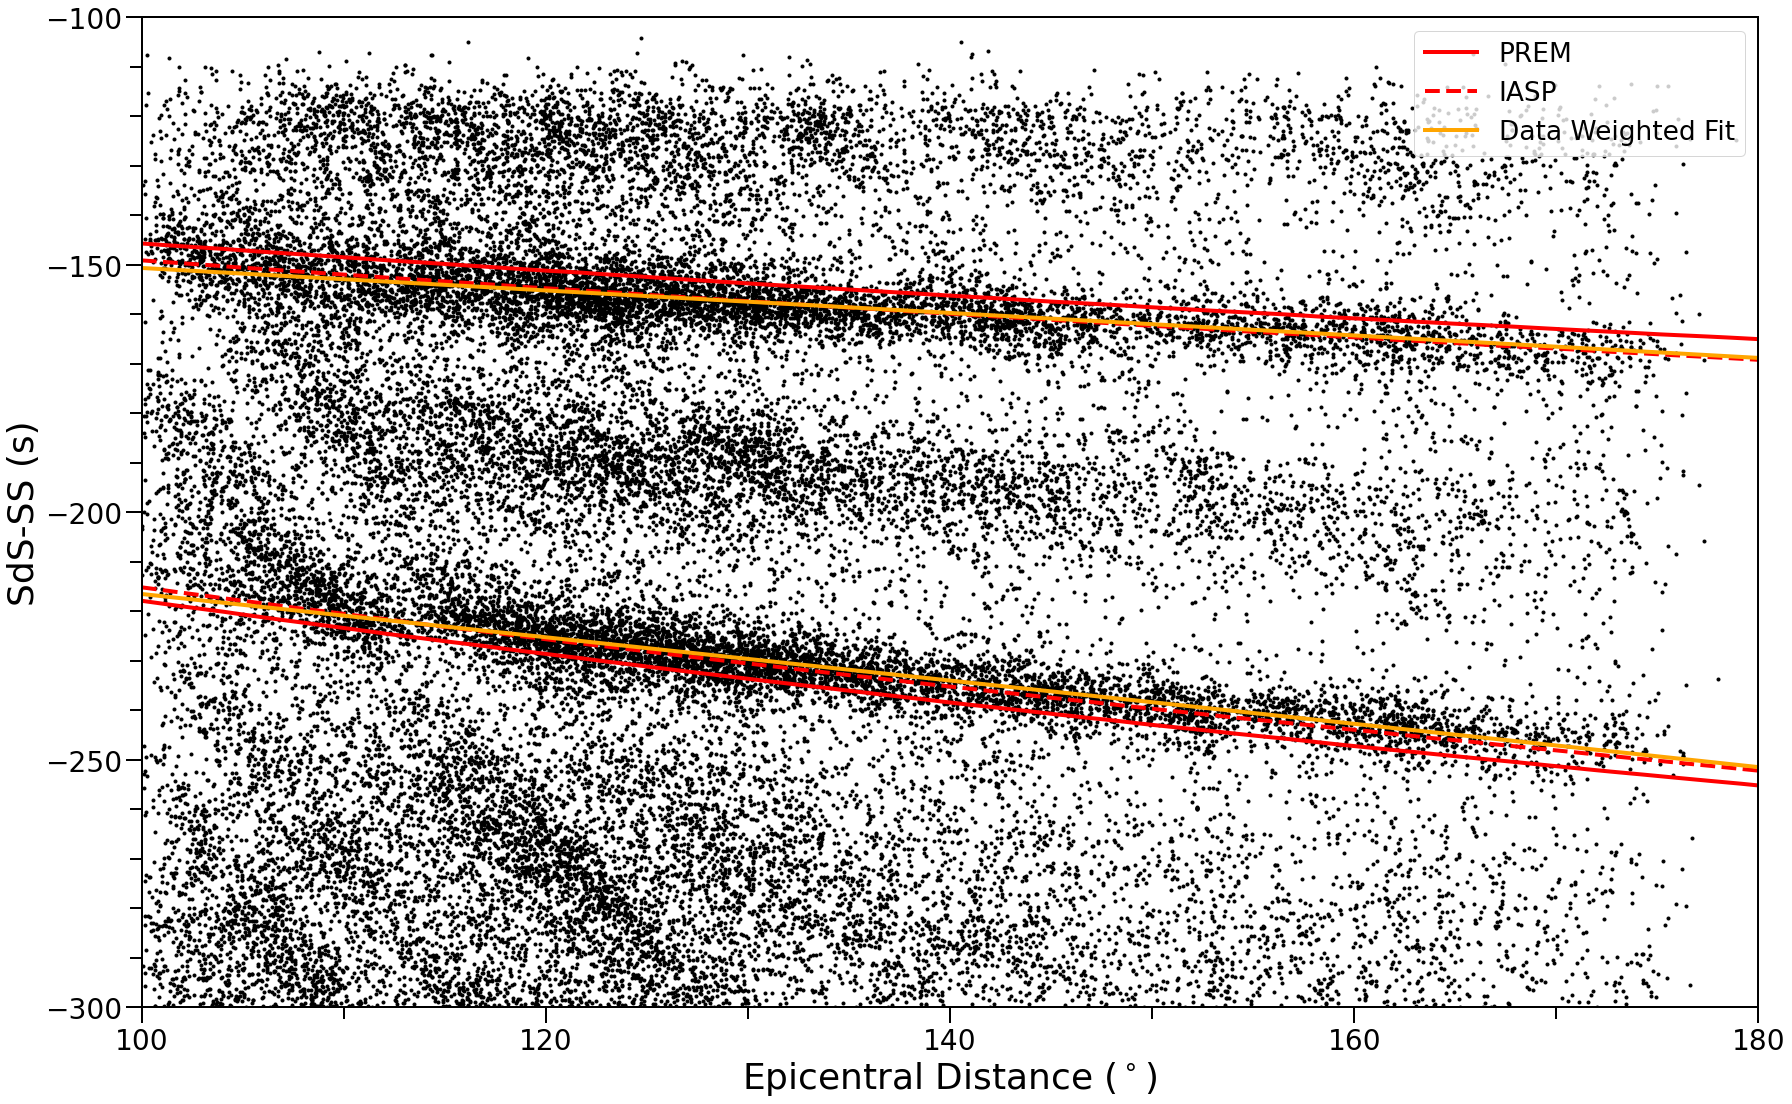

In [12]:
mpl.rcParams['axes.linewidth'] = 2

x = np.linspace(100, 180, num=100)
fig, ax = plt.subplots(figsize=(25, 25 / golden_ratio))
color = 0
if color:
    grad = amplitudes
    grad_name = 'Amplitude'
    cmin, cmax = grad.min(), grad.max()
    norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
    cmap = mpl.cm.hot_r
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    cbar.set_label(grad_name)
    ax.scatter(gcarcs[np.argsort(grad)], arrivals[np.argsort(grad)], marker='.', c=grad, cmap=cmap, norm=norm)
else:
    ax.scatter(gcarcs, arrivals, marker='.', color='black')#5, color='gainsboro')

# Theory Models
if not color:
    ax.plot(x, prem_410_0(x), color='red', linewidth=4, label='PREM')
    ax.plot(x, iasp_410_0(x), '--', color='red', linewidth=4, label='IASP')
    ax.plot(x, prem_660_0(x), color='red', linewidth=4)
    ax.plot(x, iasp_660_0(x), '--', color='red', linewidth=4)
    
    # Data Model
    ax.plot(x, model410.predict(x.reshape(-1,1)).flatten(),
            color='orange', linewidth=4, label='Data Weighted Fit')
    ax.plot(x, model660.predict(x.reshape(-1,1)).flatten(), color='orange', linewidth=4)

# Unweighted models
#ax.plot(x, model410_uw.predict(x.reshape(-1,1)).flatten(),
#        color='green', linewidth=2, label='Data Unweighted Fit')
#ax.plot(x, model660_uw.predict(x.reshape(-1,1)).flatten(), color='green', linewidth=2)

ax.set_xlim(100, 180)
ax.set_ylim(-100, -300)
ax.yaxis.set_major_locator(mtick.MultipleLocator(50))
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))
ax.xaxis.set_major_locator(mtick.MultipleLocator(20))
ax.xaxis.set_minor_locator(mtick.MultipleLocator(10))
ax.set_ylabel('SdS-SS (s)', fontsize=36)
ax.set_xlabel(r'Epicentral Distance ($^\circ$)', fontsize=36)
ax.invert_yaxis()
if not color:
    ax.legend(fontsize='large')
#ax.set_title('Qualities {}%-{}%'.format(q1*100, q2*100))
fig.tight_layout(pad=0.5)
if color:
    fig.savefig('../{}_preds_{}.pdf'.format(file, grad_name), dpi=60)
else:
    fig.savefig('../{}_preds.eps'.format(file), dpi=60)

In [13]:
import scipy as sp
def line(x, m, b):
    return m*x + b
#qualities410 = np.array(qualities410, dtype=float)
popt, pcov = sp.optimize.curve_fit(line, gcarcs410, arrivals410, sigma=qualities410)
popt

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

error: Result from function call is not a proper array of floats.

In [14]:
# need to convert qualities array to dtype float
N = gcarcs660.shape[0]
x = np.hstack([gcarcs660.reshape((N,1)), np.ones((N,1))])
y = arrivals660.reshape((N,1))
w = np.diag(qualities660)

coef = np.linalg.inv(x.T @ w @ x) @ x.T @ w @ y

y_pred = x @ coef
r = y - y_pred
var = (r**2).sum() / (x.shape[0] - x.shape[1])
cov = np.linalg.inv(x.T @ w @ x) * var
std = np.sqrt(cov.diagonal())
print(coef, std)

TypeError: No loop matching the specified signature and casting was found for ufunc inv

In [15]:
# FIG 4 B
    
q1 = 0.6
init_time = -130
end_time = -185
weighted = True
uncertainty = 5
sigmas = 2
#q2 = 0.7

condition = (arrivals < init_time) & (arrivals > end_time)
arrivals = arrivals[condition]
gcarcs = gcarcs[condition]
qualities = qualities[condition]
clustering_data = np.vstack([arrivals, gcarcs]).T

percent_data = 1
eps = 5
clusters = []
while len(clusters) < 1:
    percent_data += -0.05
    dbscan = DBSCAN(eps=eps, min_samples=len(arrivals)*percent_data)#np.round(len(df)*percent_data))
    #dbscan.fit(arrivals.reshape(-1,1))
    dbscan.fit(clustering_data)
    clusters = np.unique(dbscan.labels_)
    if -1 in clusters:
        clusters = clusters[1:]

# This groups it much better, but idk how general it is.
#dbscan = DBSCAN(eps=2.5, min_samples=100)
#dbscan.fit(clustering_data)

linear = LinearRegression()
linear.fit(gcarcs[dbscan.labels_==0].reshape(-1,1),
           arrivals[dbscan.labels_==0], sample_weight=(qualities[dbscan.labels_==0])**weighted)
arrive_linear = linear.predict(gcarcs.reshape(-1,1)).flatten()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


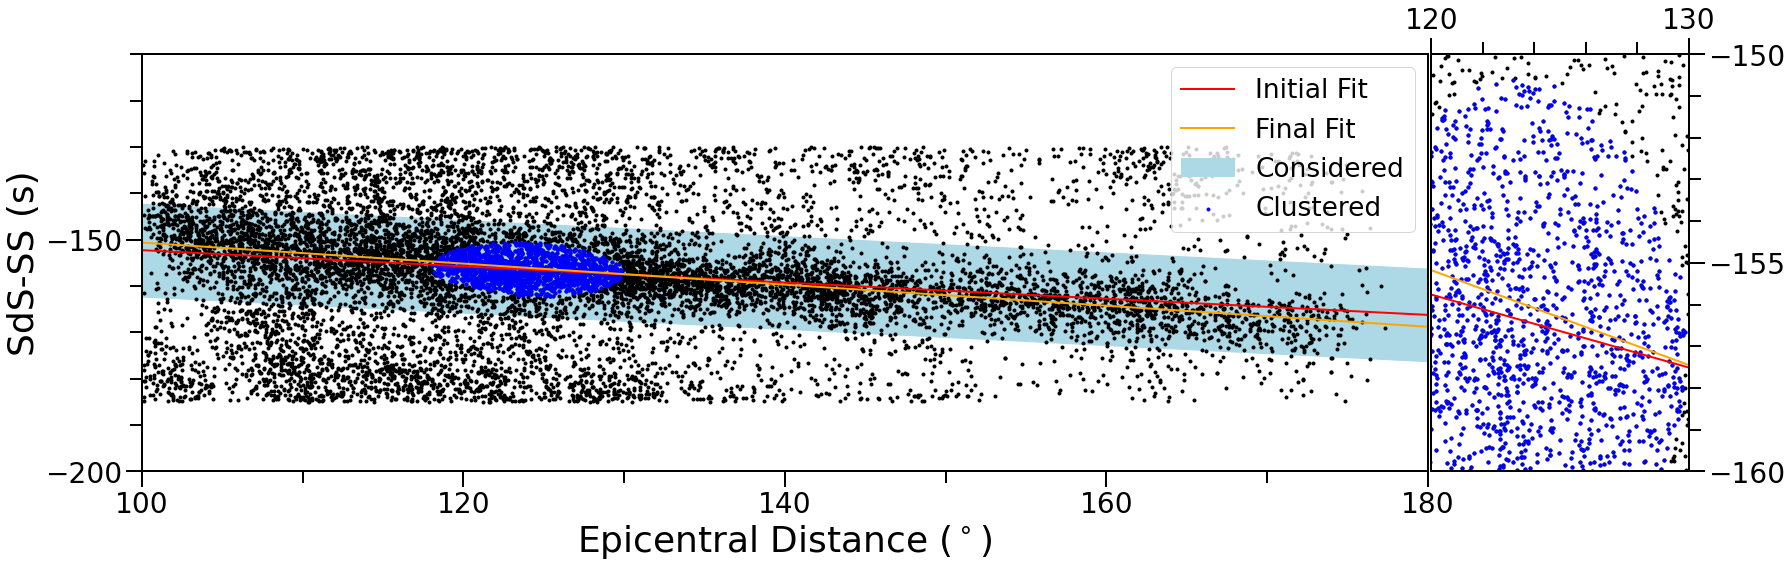

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['axes.linewidth'] = 2

x = np.linspace(100, 180, num=100)
y = linear.predict(x.reshape(-1,1))
fig, ax = plt.subplots(figsize=(25, 8))#25 / golden_ratio))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="20%", pad=0.05)

ax.set_xlim(100, 180)
ax.set_ylim(-110, -200)
ax.yaxis.set_major_locator(mtick.MultipleLocator(50))
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))
ax.xaxis.set_major_locator(mtick.MultipleLocator(20))
ax.xaxis.set_minor_locator(mtick.MultipleLocator(10))
ax.set_ylabel('SdS-SS (s)', fontsize=36)
ax.set_xlabel(r'Epicentral Distance ($^\circ$)', fontsize=36)
ax.invert_yaxis()
ax.fill_between(x, y-uncertainty*sigmas, y+uncertainty*sigmas, color='lightblue', label='Considered')
ax.scatter(gcarcs, arrivals, marker='.', color='black')
ax.scatter(gcarcs[dbscan.labels_==0], arrivals[dbscan.labels_==0], marker='.', color='blue', label='Clustered')
ax.plot(x, linear.predict(x.reshape(-1,1)).flatten(), color='red', linewidth=2, label='Initial Fit')

cax.set_xlim(120, 130)
cax.set_ylim(-150, -160)
cax.invert_yaxis()
cax.yaxis.tick_right()
cax.xaxis.tick_top()
cax.yaxis.set_major_locator(mtick.MultipleLocator(5))
cax.yaxis.set_minor_locator(mtick.MultipleLocator(1))
cax.xaxis.set_major_locator(mtick.MultipleLocator(10))
cax.xaxis.set_minor_locator(mtick.MultipleLocator(2))
cax.scatter(gcarcs, arrivals, marker='.', color='black')
cax.scatter(gcarcs[dbscan.labels_==0], arrivals[dbscan.labels_==0], marker='.', color='blue')
cax.plot(x, y.flatten(), color='red', linewidth=2)

zscore = (arrivals - arrive_linear) / uncertainty
condition = np.abs(zscore) < sigmas
gcarcs2 = gcarcs[condition]
arrivals2 = arrivals[condition]
qualities2 = qualities[condition]

linear2 = LinearRegression()
linear2.fit(gcarcs2.reshape(-1,1),
           arrivals2, sample_weight=qualities2**weighted)
ax.plot(x, linear2.predict(x.reshape(-1,1)).flatten(), color='orange', linewidth=2, label='Final Fit')
cax.plot(x, linear2.predict(x.reshape(-1,1)).flatten(), color='orange', linewidth=2)
ax.legend(fontsize='large')
fig.tight_layout(pad=0.5)
fig.savefig('../clustering_arrivals.eps', dpi=60)

/home/jorgeagr/miniconda3/envs/neuralpick/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (11,13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jorgeagr/miniconda3/envs/neuralpick/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


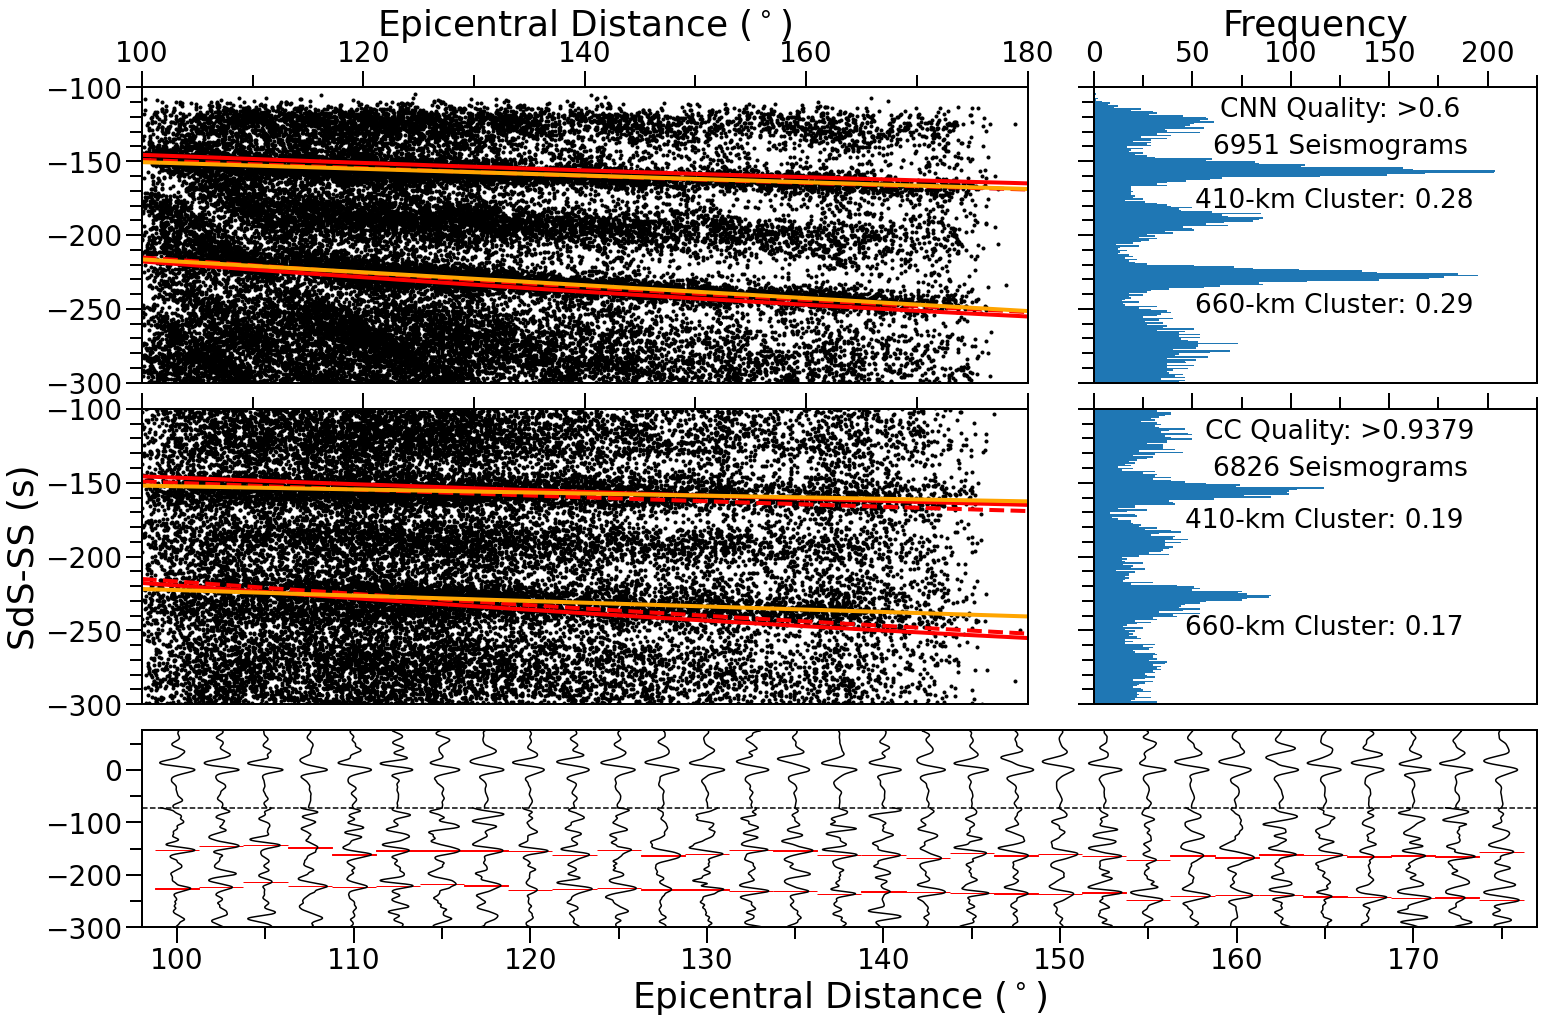

In [18]:
# FIG 5
mpl.rcParams['xtick.labelsize'] = 28
mpl.rcParams['ytick.labelsize'] = 28

def get_Predictions_CC(window_size, qual_cut=0.6):
    df = pd.read_csv('/home/jorgeagr/seismology/experimental/ss_ind_precursors/crosscorr{}.txt'.format(window_size),
                     header=None, sep=' ')
    df = df.fillna(0)
    pred_inds = np.array([1, 4, 7, 10, 13])
    
    gcarcs = np.zeros(len(df))
    df_model = pd.read_csv('/home/jorgeagr/seismology/experimental/ss_ind_precursors/SS_corrected_preds.csv')
    for i, file in enumerate(df[0].values):
        if file.rstrip('.s_fil') in df_model['file'].values:
            gcarcs[i] = df_model.loc[i,'gcarc']
    
    df = df.loc[gcarcs > 0, :]
    df['gcarcs'] = gcarcs
    df.loc[:, 13] = pd.to_numeric(df[13], errors='coerce')
    
    files = df[0].values
    arrivals = df.values[:,pred_inds].astype(np.float)#.flatten()
    gcarcs = df['gcarcs']
    qualities = df.values[:,pred_inds+2].astype(np.float)
    
    arrivals[qualities < qual_cut] = 0
    qualities = qualities.flatten()
    arrivals_inds = np.meshgrid(np.arange(arrivals.shape[1]),
                               np.arange(arrivals.shape[0]))[1].flatten()
    gcarcs = np.meshgrid(np.arange(arrivals.shape[1]), gcarcs)[1].flatten()
    files = np.meshgrid(np.arange(arrivals.shape[1]), files)[1].flatten()
    arrivals = arrivals.flatten()
    
    arrivals_inds, gcarcs, qualities, arrivals, files = filter_Data(arrivals != 0, arrivals_inds, gcarcs,
                                                                           qualities, arrivals, files)
    arrivals_inds, gcarcs, qualities, arrivals, files = filter_Data(gcarcs >= 100, arrivals_inds, gcarcs,
                                                                           qualities, arrivals, files)
    arrivals_inds, gcarcs, qualities, arrivals, files = filter_Data(arrivals > -300, arrivals_inds, gcarcs,
                                                                           qualities, arrivals, files)
    
    return gcarcs, arrivals, qualities, files
  

# 410 models
prem_410_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '410', '0', 'prem')
iasp_410_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '410', '0', 'iasp')
# 660 models
prem_660_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '660', '0', 'prem')
iasp_660_0 = discontinuity_model('/home/jorgeagr/seismology/experimental/ss_ind_precursors/phase_times/',
                                '660', '0', 'iasp')
x = np.linspace(100, 180, num=100)
#fig = plt.figure(figsize=(25, 25 / golden_ratio))
#a3 = plt.subplot2grid((8,3), (3,0), colspan=2, rowspan=3, fig=fig)
#a4 = plt.subplot2grid((8,3), (3,2), colspan=1, rowspan=3, sharey=a3, fig=fig)
#a1 = plt.subplot2grid((8,3), (0,0), colspan=2, rowspan=3, sharex=a3, fig=fig)
#a2 = plt.subplot2grid((8,3), (0,2), colspan=1, rowspan=3, sharey=a1, sharex=a4, fig=fig)
#a5 = plt.subplot2grid((8,3), (6,0), colspan=3, rowspan=2, fig=fig)  
#ax = [[a1, a2],
#      [a3, a4],
#      a5,]

fig = plt.figure(figsize=(25, 25 / golden_ratio), constrained_layout=False)
grid = fig.add_gridspec(ncols=2,nrows=3, wspace=0.1, hspace=0.1, width_ratios=[2, 1], height_ratios=[3, 3, 2])
a1 = fig.add_subplot(grid[0, 0])
a2 = fig.add_subplot(grid[0, 1])
a3 = fig.add_subplot(grid[1, 0])
a4 = fig.add_subplot(grid[1, 1])
#grid2 = fig.add_gridspec(ncols=2, nrows=1, hspace=0.2)
a5 = fig.add_subplot(grid[-1, :])
ax = [[a1, a2],
      [a3, a4],
     a5]

g_i = 120
g_f = g_i + 10
titles = ('CNN: {} to {} deg / >{} Quality / {} Seismograms', 'CC: {} to {} deg / >{} Quality / {} Seismograms')
for i in [1, 0]:
    if i == 0:
        q1 = 0.6
        #q2 = 0.7
        file = 'corrected'
        gcarcs, arrivals, errors, qualities, amplitudes, files = get_Predictions('/home/jorgeagr/seismology/experimental/ss_ind_precursors/',
                                    'SS_{}_preds.csv'.format(file), qual_cut=q1)
    else:
        q1 = 0.9379
        gcarcs, arrivals, qualities, files = get_Predictions_CC(20, qual_cut=q1)
        errors = qualities
    
    gcarcs410, arrivals410, errors410, qualities410, files410, model410 = find_Relevant(arrivals, gcarcs, errors, qualities, files,
                                                                              -130, -185, 5, 2) 
    gcarcs660, arrivals660, errors660, qualities660, files660, model660 = find_Relevant(arrivals, gcarcs, errors, qualities, files,
                                                                              -200, -250, 5, 2)
    
    ax[i][0].scatter(gcarcs, arrivals, marker='.', color='black')
    ax[i][0].plot(x, prem_410_0(x), color='red', linewidth=4, label='PREM')
    ax[i][0].plot(x, iasp_410_0(x), '--', color='red', linewidth=4, label='IASP')
    ax[i][0].plot(x, prem_660_0(x), color='red', linewidth=4)
    ax[i][0].plot(x, iasp_660_0(x), '--', color='red', linewidth=4)
    ax[i][0].plot(x, model410.predict(x.reshape(-1,1)).flatten(),
            color='orange', linewidth=4, label='Data Weighted Fit')
    ax[i][0].plot(x, model660.predict(x.reshape(-1,1)).flatten(), color='orange', linewidth=4)
    ax[i][0].set_xlim(100, 180)
    ax[i][0].set_ylim(-100, -300)
    ax[i][0].yaxis.set_major_locator(mtick.MultipleLocator(50))
    ax[i][0].yaxis.set_minor_locator(mtick.MultipleLocator(10))
    ax[i][0].xaxis.set_major_locator(mtick.MultipleLocator(20))
    ax[i][0].xaxis.set_minor_locator(mtick.MultipleLocator(10))
    ax[i][0].xaxis.tick_top()
    ax[i][1].xaxis.tick_top()
    if i == 0:
        ax[i][0].set_xlabel(r'Epicentral Distance ($^\circ$)', fontsize=36)
        ax[i][1].set_xlabel('Frequency', fontsize=36)
        plt.setp(ax[i][1].get_yticklabels(), visible=False)
        ax[i][0].xaxis.set_label_position('top')
        ax[i][1].xaxis.set_label_position('top')
    if i == 1:
        ax[i][0].set_ylabel('SdS-SS (s)', fontsize=36)
        plt.setp(ax[i][0].get_xticklabels(), visible=False)
        plt.setp(ax[i][1].get_xticklabels(), visible=False)
        plt.setp(ax[i][1].get_yticklabels(), visible=False)
        #ax[i][0].legend()
        #ax[i][1].set_title('Picks from {} to {} deg'.format(g_i, g_f))
    ax[i][0].invert_yaxis()
    
    ax[i][1].set_ylim(-300, -100)
    ax[i][1].set_xlim(0, 225)
    seis_total = np.unique(files[(g_i < gcarcs) & (gcarcs < g_f)]).shape[0]
    seis_410 = np.unique(files410[(g_i < gcarcs410) & (gcarcs410 < g_f)]).shape[0]
    seis_660 = np.unique(files660[(g_i < gcarcs660) & (gcarcs660 < g_f)]).shape[0]
    freq, _, _ = ax[i][1].hist(arrivals[(g_i < gcarcs) & (gcarcs < g_f)],
                   np.arange(-300, -100, 1), color='tab:blue', orientation="horizontal")
    freq410, _, _ = ax[i][1].hist(arrivals410[(g_i < gcarcs410) & (gcarcs410 < g_f)],
                      np.arange(-300, -100, 1), color='tab:blue', orientation="horizontal")
    freq660, _, _ = ax[i][1].hist(arrivals660[(g_i < gcarcs660) & (gcarcs660 < g_f)],
                      np.arange(-300, -100, 1), color='tab:blue', orientation="horizontal")
    if i == 0:
        ax[i][1].text(125, -120, 'CNN Quality: >{}'.format(q1), ha='center', fontsize='large')
        ax[i][1].text(125, -145, '{} Seismograms'.format(seis_total), ha='center', fontsize='large')
        ax[i][1].text(freq410.max()/2+20, model410.predict(np.array([[g_i + 5]]))[0]-25, '410-km Cluster: {:.2f}'.format(seis_410/seis_total), ha='center', fontsize='large')
        ax[i][1].text(freq410.max()/2+20, model660.predict(np.array([[g_i + 5]]))[0]-25, '660-km Cluster: {:.2f}'.format(seis_660/seis_total), ha='center', fontsize='large')
    else:
        ax[i][1].text(125, -120, 'CC Quality: >{}'.format(q1), ha='center', fontsize='large')
        ax[i][1].text(125, -145, '{} Seismograms'.format(seis_total), ha='center', fontsize='large')
        ax[i][1].text(freq410.max(), model410.predict(np.array([[g_i + 5]]))[0]-25, '410-km Cluster: {:.2f}'.format(seis_410/seis_total), ha='center', fontsize='large')
        ax[i][1].text(freq410.max(), model660.predict(np.array([[g_i + 5]]))[0]-25, '660-km Cluster: {:.2f}'.format(seis_660/seis_total), ha='center', fontsize='large')
    #ax[i][1].text(model410.predict(np.array([[g_i + 5]]))[0]-10, freq410.max()+0.5, '410-km Cluster: {:.2f}'.format(seis_410/seis_total))
    #ax[i][1].text(model660.predict(np.array([[g_i + 5]]))[0]-10, freq660.max()+0.5, '660-km Cluster: {:.2f}'.format(seis_660/seis_total))
    #ax[i][1].set_title(titles[i].format(g_i, g_f, q1, seis_total))
    ax[i][1].xaxis.set_major_locator(mtick.MultipleLocator(50))
    ax[i][1].xaxis.set_minor_locator(mtick.MultipleLocator(25))
    ax[i][1].yaxis.set_major_locator(mtick.MultipleLocator(50))
    ax[i][1].yaxis.set_minor_locator(mtick.MultipleLocator(10))

df410 = pd.DataFrame(data={'file':files410,
                           'time': arrivals410,
                           'error': errors410,
                           'quality': qualities410})
df660 = pd.DataFrame(data={'file': files660,
                           'time': arrivals660,
                           'error': errors660,
                           'quality': qualities660})

dfboth = pd.merge(df410, df660, how='inner', on=['file'])
bin = 2.5
t, ep = np.meshgrid(np.arange(0, 497.3, 0.1), np.arange(100, 180-bin, bin))
amp = np.zeros(t.shape)
ar = np.zeros((len(amp), 2))
er = np.zeros(ar.shape)
for i in range(ep.shape[0]):
    q = 0.9
    while (amp[i] == np.zeros_like(len(amp[i]))).sum() == len(amp[i]):
        for f in dfboth[((dfboth['quality_x'] > q) & (dfboth['quality_y'] > q))].sort_values('quality_y', ascending=False)['file'].values:
            if ep[i,0] < gcarcs[files == f][0] < ep[i,0]+bin:
                seis = obspy.read('/mnt/d/SS_corrected/{}.s_fil'.format(f))[0].resample(10)
                #print(gcarcs[files == f][0], dfboth[dfboth.file == f].quality_x.values[0], dfboth[dfboth.file == f].quality_y.values[0])
                amp[i] = seis.data[:4973]
                ar[i,0] = dfboth[dfboth.file == f].time_x.values[0]
                ar[i,1] = dfboth[dfboth.file == f].time_y.values[0]
                er[i,0] = dfboth[dfboth.file == f].error_x.values[0]
                er[i,1] = dfboth[dfboth.file == f].error_y.values[0]
                break
        q += -0.05
        if q <= 0.6:
            break
init = 1000
cut = 3500
ax[2].axhline(cut/10 + seis.stats.sac.b, color='black', linestyle='--')
ax[2].set_xlim(98, 177)
ax2 = ax[2].twiny()
ax2.set_xlim(98, 1http://127.0.0.1:8888/?token=b4e6caf16281a32520c2183b5bda14c7428a7efd90c7577377)
ax[2].set_ylim(-300,seis.stats.sac.e)
ax2.set_ylim(-300,seis.stats.sac.e)
for i in range(ep.shape[0]):
    mina = np.abs(amp[i,init:cut]).min()
    maxa = np.abs(amp[i,init:cut]).max()
    ax[2].plot(amp[i,init:cut]/maxa+ep[i,0], t[i,init:cut]+seis.stats.sac.b, color='black')
    for j in range(2):
        x_grid = np.array([ep[i,j] - bin/2, ep[i,j] + bin/2])
        ax[2].fill_between(x_grid, ar[i,j] - er[i,j]*2, ar[i,j] + er[i,j]*2, color='red')
    #ax.axvline(ar[i,0], (ep[i,0]-2.5 - 99)/(176-99), (ep[i,0]+2.5 - 99)/(176-99), color='red')
    #ax.axvline(ar[i,1], ep[i,0]-1, ep[i,0]+1)
    ax2.plot(amp[i,cut:]/np.abs(amp[i,cut:]).max()+ep[i,0], t[i,cut:]+seis.stats.sac.b, color='black')
ax2.axes.get_xaxis().set_visible(False)    
#ax[2].set_ylabel('Time (s)')
ax[2].set_xlabel(r'Epicentral Distance ($^\circ$)', fontsize=36)
ax[2].xaxis.set_major_locator(mtick.MultipleLocator(10))
ax[2].xaxis.set_minor_locator(mtick.MultipleLocator(5))
ax[2].yaxis.set_major_locator(mtick.MultipleLocator(100))
ax[2].yaxis.set_minor_locator(mtick.MultipleLocator(50))
#ax[2].invert_xaxis()
#ax2.invert_xaxis()

fig.tight_layout(pad=0.5)
fig.savefig('../preds_410_660.eps'.format(file), dpi=60)